# Automatic E-mail Classification

This project attempts to accurately classify e-mails into folders using e-mail content, such as an e-mail's headers and its body.  This is a Natural Language Processing challenge that aims to make sense of text documents, by converting text into numerical feature vectors using a [Bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) model.

Undoubtedly, categorizing e-mails based on the content poses many challenges.  In reality, there is a constant stream of new information being passed through e-mails each day and what we learn from previous e-mails may not be able to tell us much about future e-mails.  E-mail threads will branch off onto new topics, and each user organizes their e-mails in different ways.  As a result, the user ididiosyncrasies will affect the performance of any standard classifier.

I found e-mail classification to be an interesting angle to tackle the Enron Corpus, the largest public domain database in the world containing real-world email messages.  I will attempt to use [multiclass classification](https://en.wikipedia.org/wiki/Multiclass_classification) to classify e-mails beloning to several employees, many of which actively used multiple folders to organize their e-mails.  

The dataset contains over 500,000 emails from about 150 users, mostly senior management at Enron. You can visit [here](https://en.wikipedia.org/wiki/Enron_scandal) to learn more about the Enron scandal.  You could also download a copy of the dataset [here](https://www.cs.cmu.edu/~./enron/).  

Benchmark results for this project can be found [here](http://scholarworks.umass.edu/cgi/viewcontent.cgi?article=1217&context=cs_faculty_pubs).  Bekkerman et al. (Ron Bekkerman, Andrew McCallum and Gary Huang). *Automatic Categorization of Email into Folders: Benchmark Experiments on Enron and SRI Corpora*

##  Exploring the Enron Emails Dataset

### Read CSV file into DataFrame

In [1]:
import pandas as pd
pd.set_option("display.max_rows", 999)
pd.set_option('max_colwidth',100)
import numpy as np
from IPython.display import display

filepath = "data/emails.csv"
# Read the data into a pandas dataframe called emails
emails = pd.read_csv(filepath)
headers = [header for header in emails.columns]
print("Successfully loaded {} rows and {} columns!".format(emails.shape[0], emails.shape[1]))
print(display(emails.head()))

Successfully loaded 517401 rows and 2 columns!


,file,message
0,allen-p/_sent_mail/1.,"Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>\nDate: Mon, 14 May 2001 16:39:00 -0700..."
1,allen-p/_sent_mail/10.,"Message-ID: <15464986.1075855378456.JavaMail.evans@thyme>\nDate: Fri, 4 May 2001 13:51:00 -0700 ..."
2,allen-p/_sent_mail/100.,"Message-ID: <24216240.1075855687451.JavaMail.evans@thyme>\nDate: Wed, 18 Oct 2000 03:00:00 -0700..."
3,allen-p/_sent_mail/1000.,"Message-ID: <13505866.1075863688222.JavaMail.evans@thyme>\nDate: Mon, 23 Oct 2000 06:13:00 -0700..."
4,allen-p/_sent_mail/1001.,"Message-ID: <30922949.1075863688243.JavaMail.evans@thyme>\nDate: Thu, 31 Aug 2000 05:07:00 -0700..."


None


Numpy and pandas are imported, then the CSV file containing the e-mails is read into a dataframe called **`emails`**.  The reading may take a while due to the size of the file.  Here is a description of each column:

**`file`** - contains the original directory and filename of each email. The root level of this path is the employee (surname first followed by first name initial) to whom the e-mails belong. 

**`message`** - contains the email text document

### A sample e-mail

Here is a sample of the standard e-mail found in the data.  It contains a list of headers and a message body.  Python has a built in [MIME handling package](https://docs.python.org/2/library/email.html) that will be used to extract the data needed from each e-mail.

In [2]:
print(emails.loc[0]["message"])

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


### Features and Label

Headers such as `To`, `Subject`, `From` and the message body are used as features.  The `X-Folder` contains the label. All the features are in strings will need to be converted into numerical format for the computer to interpret them.  

### Extract headers

The heads are extracted and added to **`emails`**

In [3]:
import email

def insert_value(dictionary, key, value):
    if key in dictionary:
        values = dictionary.get(key)
        values.append(value)
        dictionary[key] = values
    else:
        dictionary[key] = [value]
    return dictionary

def get_headers(df, header_names):
    headers = {}
    messages = df["message"]
    for message in messages:
        e = email.message_from_string(message)
        for item in header_names:
            header = e.get(item)
            insert_value(dictionary = headers, key = item, value = header) 
    print("Successfully retrieved header information!")
    return headers
header_names = ["Date", "Subject", "X-Folder", "X-From", "X-To"]    
headers = get_headers(emails, header_names)

Successfully retrieved header information!


###  Extract Message Body

The message body is extracted and added as a new column called **`Message_Body`** to **`emails`**

In [4]:
def get_messages(df):
    messages = []
    for item in df["message"]:
        # Return a message object structure from a string
        e = email.message_from_string(item)    
        # get message body  
        message_body = e.get_payload()
        message_body = message_body.lower()
        messages.append(message_body)
    print("Successfully retrieved message body from e-mails!")
    return messages
msg_body = get_messages(emails)
emails["Message-Body"] = msg_body

Successfully retrieved message body from e-mails!


### Get Employee names

A sample of unique values from the `X-From` column shows that there are some e-mails sent from non-employees, such as bloomberg.com and earnings.com.  For unique employee names, it would be more suitable to use the employee names found in the `file` column of the `emails` dataframe.  It is a part of a string with other info and will have to be extracted and added to `emails`.  The employee names could be used to filter the data for records pertaining to each employee.

In [5]:
x_from = pd.DataFrame(headers["X-From"], columns = ["X-From"])
print(x_from.iloc[:1000]["X-From"].unique()[:10])
if "X-From" not in emails.columns:
    emails = pd.concat([emails, x_from], axis = 1, join = 'inner')

['Phillip K Allen' 'Ina Rangel'
 'Multex Investor <1.11913372.-2@multexinvestornetwork.com>'
 '"Bloomberg.com" <messenger@ecm.bloomberg.com>'
 '"Arthur O\'Donnell" <aod@newsdata.com>' 'critical.notice@Enron.com'
 'market-reply@LISTSERV.DOWJONES.COM' 'Rebecca W Cantrell'
 '"Earnings.com" <webmaster@earnings.com>' 'Paul Kaufman']


In [6]:
def add_name(df, column, labels):
    new_data = {}
    for item in df[column]: 
        tokens = item.split('/')
        for i in range(0, len(labels)):
            value = tokens[i]
            key = labels[i]
            new_data = insert_value(new_data, key, value)        
    for key, value in new_data.items():
        df[key] = pd.Series(value)
    print("Successfully added new column!")
    return df
emails = add_name(df = emails, column = "file", labels = ["employee"])

Successfully added new column!


### A look at the folders

In [7]:
def add_headers(df, header_list):
    for label in header_list:
        df_new = pd.DataFrame(headers[label], columns = [label])
        if label not in df.columns:
            df = pd.concat([df, df_new], axis = 1)
    return df
remaining_headers = ["Date", "Subject", "X-To", "X-From", "X-Folder"]
emails = add_headers(df = emails, header_list = remaining_headers)
print("Here is the emails dataframe after appending all the relevant headers")
print(display(emails.iloc[:1]))

Here is the emails dataframe after appending all the relevant headers


,file,message,Message-Body,X-From,employee,Date,Subject,X-To,X-Folder
0,allen-p/_sent_mail/1.,"Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>\nDate: Mon, 14 May 2001 16:39:00 -0700...",here is our forecast\n\n,Phillip K Allen,allen-p,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",,Tim Belden <Tim Belden/Enron@EnronXGate>,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail"


None


A sample of randomly selected folders from a newly created `folders` dataframe shows that there were multiple unique folders used by employees. 

In [8]:
print(emails["X-Folder"].sample(7))

190444                 \Tanya_Jones_Dec2000\Notes Folders\Notes inbox
447153                       \MSMITH18 (Non-Privileged)\Deleted Items
300736                  \Kay_Mann_June2001_4\Notes Folders\'sent mail
342814           \Scott_Neal_Jun2001\Notes Folders\Discussion threads
355380              \JPARKS (Non-Privileged)\Parks, Joe\Deleted Items
116216    \Drew_Fossum_Dec2000_June2001_2\Notes Folders\All documents
447769                    \MSMITH18 (Non-Privileged)\Pipeline Matters
Name: X-Folder, dtype: object


### Visualize folders by size

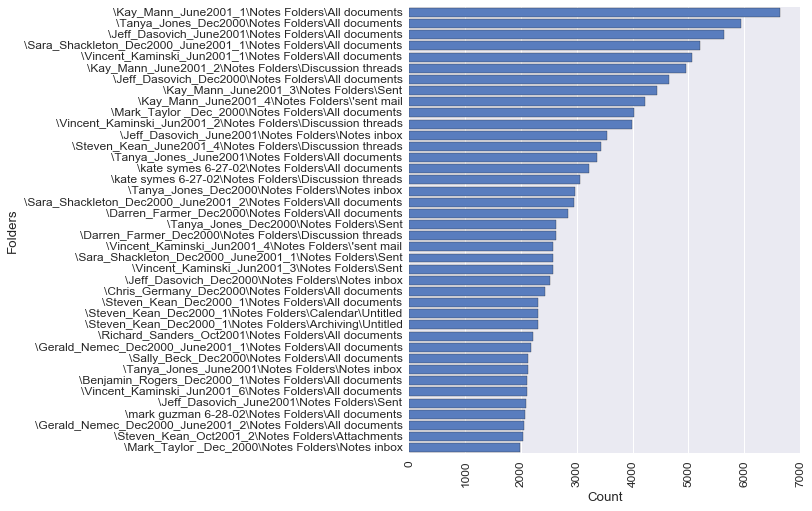

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# dataframe containing counts of every word in the emails dataframe
email_count = emails["X-Folder"].value_counts()
indices = email_count.index
count = pd.DataFrame(email_count, columns = ["X-Folder"])
count["Folder Names"] = indices
#print count.head()

def barplot(df, X, Y, figsize, color, orient, ylabel, xlabel, font_scale, rotation):
    f, ax = plt.subplots(figsize=figsize)
    sns.set_color_codes("muted")
    sns.barplot(x = X, y = Y, data = df, color = color, orient = orient)
    ax.set(ylabel = ylabel, xlabel = xlabel)
    sns.set(font_scale = font_scale)
    plt.xticks(rotation = rotation) 
    sns.plt.show()
    
barplot(df = count[:40], X = "X-Folder", Y = "Folder Names", figsize = (7, 8), color = 'b', orient = 'h', ylabel = "Folders", xlabel = "Count", font_scale = 1.2, rotation = 90)

**Figure 1**: Bar plot showing 40 folders that contain the most e-mails 

A look into `williams-w3` folder counts and you will see that the `schedule crawler` and `bill williams iii` contained lots of e-mails and were the most used by this employee.  These two folders were also in the top 5 largest folders used by any employee at Enron.

In [485]:
williams = emails[emails["employee"] == "williams-w3"]
williams["X-Folder"].value_counts()[:8]

\ExMerge - Williams III, Bill\Schedule Crawler             1398
\Williams III, Bill (Non-Privileged)\Bill Williams III     1022
\ExMerge - Williams III, Bill\Sent Items                    519
\ExMerge - Williams III, Bill\Inbox                         137
\ExMerge - Williams III, Bill\HR                             86
\ExMerge - Williams III, Bill\SymesEES                       81
\ExMerge - Williams III, Bill\Human Resources                45
\ExMerge - Williams III, Bill\Operations Committee/ISAS      19
Name: X-Folder, dtype: int64

### Visualize e-mail count by employee

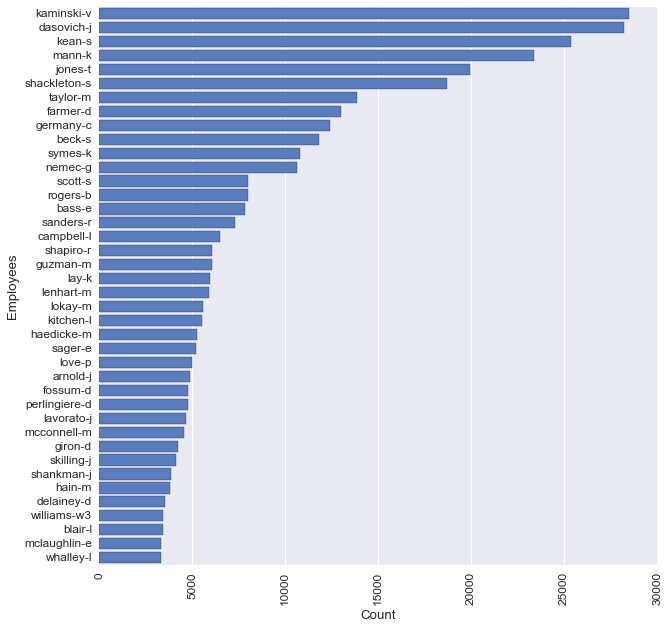

In [527]:
mail_count = emails["employee"].value_counts()
indices = mail_count.index
count = pd.DataFrame(mail_count)
count.rename(columns = {"employee": "Count"}, inplace = True)
count["Employees"] = indices
barplot(df = count[:40], X = "Count", Y = "Employees", figsize = (10, 10), color = 'b', orient = 'h', ylabel = "Employees", xlabel = "Count", font_scale = .8, rotation = 90)

**Figure 2**: Bar graph showing 40 employees who had the highest number of sent e-mails

Here are the list of things that needs to be performed on the data:

* Convert `date` column to datetime
* Remove non-topical folders
* Remove folders containing too few e-mails (less than 2)
* Select employees with over 1000 e-mails 
* Drop rows with missing values
* Encode class labels
* Bag-of-words model
    * Tokenization
    * Remove unwanted characters from the `message`, `Subject`, `X-To` and `X-From` columns
    * Assemble matrices
    * Count tokens
    * Remove stop-words

In [304]:
# Convert date column to datetime 
emails["Date"] = pd.to_datetime(emails["Date"])
print(emails.iloc[:1]["Date"])

0   2001-05-14 23:39:00
Name: Date, dtype: datetime64[ns]


### Remove Non-topical Folders

The `X-Folder` column contains several folders and subfolders that are not needed.  These include non-topical folders, which refer to folders that hold e-mails regardless of content.  These are removed because it is pretty hard to accurately train a classifier using them. Here's a few non-topical folders:
* all_documents
* discussion_threads
* sent
* deleted_items
* inbox
* sent_items
* notes_inbox
* _sent_mail
* calendar  

In [40]:
def preprocess_folder(data):
    folders = []
    for item in data:
        if item is None or item is '':
            folders.append(np.nan)
        else:
            item = item.split("\\")[-1]
            item = item.lower()
            folders.append(item)
    print("Folder cleaned!")
    return folders      
emails["X-Folder"] = preprocess_folder(emails["X-Folder"])   

Folder cleaned!


In [41]:
# Folder count
print(emails["X-Folder"].value_counts())[:15]

all documents         128103
discussion threads     58609
sent                   58168
deleted items          50986
inbox                  41507
sent items             37920
notes inbox            36665
'sent mail             30237
untitled                8957
personal                2642
attachments             2026
meetings                1872
calendar                1732
schedule crawler        1398
logistics               1192
Name: X-Folder, dtype: int64


In [42]:
# Folders we can filter out
unwanted_folders = ["all documents", "deleted items", "discussion threads", "sent", "deleted Items", "inbox",
                   "sent items", "'sent mail", "untitled", "notes inbox", "junk file", "calendar"]

# A new dataframe without non-topical folders
emails = emails.loc[~emails['X-Folder'].isin(unwanted_folders)]
print(emails["X-Folder"].value_counts())[:15]

personal               2642
attachments            2026
meetings               1872
schedule crawler       1398
logistics              1192
tw-commercial group    1159
california             1052
bill williams iii      1022
deal discrepancies      897
management              802
esvl                    715
e-mail bin              614
tufco                   609
resumes                 609
ces                     576
Name: X-Folder, dtype: int64


### Extract e-mails for employees who had over 2000 e-mails

In [43]:
email_count = dict(emails["employee"].value_counts())
reduced_emails = [key for key, val in email_count.items() if val >= 2000]
emails = emails.loc[emails['employee'].isin(reduced_emails)]
print(emails["employee"].value_counts())

kean-s         5550
kaminski-v     4483
kitchen-l      4034
farmer-d       3786
williams-w3    2775
lokay-m        2554
taylor-m       2477
shapiro-r      2036
beck-s         2013
Name: employee, dtype: int64


### Missing Values

We see that the **`X-From`**, **`Folder`**, and **`X-To`** columns contain missing values.  Given that the number of missing values is relatively small compared to the size of the entire dataset, we can go ahead and drop the rows containing these missing values

In [44]:
emails.isnull().sum()

file            0
message         0
Message-Body    0
X-From          3
employee        0
Date            0
Subject         0
X-To            3
X-Folder        3
dtype: int64

In [45]:
emails.dropna(inplace = True)
print("Rows with missing values have been removed")
emails.isnull().sum()

Rows with missing values have been removed


file            0
message         0
Message-Body    0
X-From          0
employee        0
Date            0
Subject         0
X-To            0
X-Folder        0
dtype: int64

### Bag-of-words model

For the computer to make inferences of the e-mails, it has to be able to interpret the text by making a numerical representation of it.  One way to do this is by using something called a [**Bag-of-words model**](https://en.wikipedia.org/wiki/Bag-of-words_model).  It will take the e-mails as a string and convert it into a numerical vector to show the frequency that each unique word appears over the entire dataset.  

### Tokenization 

In [46]:
def tokenize(row):
    if row is None or row is '':
        tokens = ""
    else:
        tokens = row.split(" ")
    return tokens

### Remove regular expressions

The regular expressions, which includes punctuation marks and nonword characters need to be removed.  I will use Python's regular expression ([regex](https://docs.python.org/2/library/re.html)) libary to remove these characters.

In [47]:
import re

def remove_reg_expressions(row):
    tokens = []
    try:
        for token in row:
            token = token.lower()
            token = re.sub(r'[\W\d]', " ", token)
            tokens.append(token)
    except:
        token = ""
        tokens.append(token)
    return tokens

### Stop-word removal

Stop-words are also removed.  Stop-words are words that are very common in text but offer no useful information that can be used to classify the text.  Words such as *is*, *and*, *the*, *are* are examples of stop-words.  The [NLTK library](http://www.nltk.org) contains a list of 127 English stop-words and can be used to filter our tokenized strings.

In [48]:
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')    

def stop_word_removal(row):
    token = [token for token in row if token not in stopwords]
    token = filter(None, token)
    return token

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/donaldfung/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Assemble matrices

The **`assemble_bag()`** function will call the **`tokenize()`**, **`remove_reg_expressions()`**, **`stop_word_removal()`** functions to clean the data.  Then it assembles a new dataframe containing all the unique words found in the text documents.  It counts the word frequency and then returns the new dataframe.  

In [49]:
def assemble_bag(data):
    data = data.apply(tokenize)
    data = data.apply(stop_word_removal)
    data = data.apply(remove_reg_expressions)
    
    unique_tokens = []
    single_tokens = []

    for item in data:
        for token in item:
            if token in single_tokens:
                if token not in unique_tokens:
                    unique_tokens.append(token)
            else:
                single_tokens.append(token)
    
    df = pd.DataFrame(0, index = np.arange(len(data)), columns = unique_tokens)
    
    for i, item in enumerate(data):
        for token in item:
            if token in unique_tokens:
                df.iloc[i][token] += 1    
    return df

## Multiclass Classification using Logistic Regression

Here we focus on just one Enron employee for our classification problem.  After seeing the steps involved in classifying one employee's e-mails, we can apply the same approach for a few other employees.  

#### Choose an employee

In [50]:
employee = emails[emails["employee"] == "kaminski-v"]

### Remove folders

We also remove folders that do not contain enough e-mails because such folders would not be significant for training our classifier.  Also, we can also infer that some folders with very little e-mails in them were created but unused.

In [51]:
def remove_folders(emails, n):
    # Returns the folders containing more than 'n' number of e-mails
    email_count = dict(emails["X-Folder"].value_counts())
    small_folders = [key for key, val in email_count.items() if val <= n]
    emails = emails.loc[~emails['X-Folder'].isin(small_folders)]
    return emails

In [52]:
n = 200
employee = remove_folders(employee, n)
print("Folders with less than {} e-mails removed!\nThis is a list of the 5 smallest folders\n").format(n)

Folders with less than 200 e-mails removed!
This is a list of the 5 smallest folders



### Encoding class labels

The folders in the **`Folders`** column need to be converted into integers so that the learning algorithm can interpret the data correctly.  These folders are categorical and as such, it does not matter which integer is assigned to a particular folder.  Scikit-learn has a [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) class that can implement this conversion.  The conversion was applied and assigned to a new column, **`y`**, which we will use as our preprocessed set of labels

In [53]:
from sklearn.preprocessing import LabelEncoder

def label_encoder(df):
    class_le = LabelEncoder()
    # apply label encoder on the `Folder` column
    y = class_le.fit_transform(df['X-Folder'])
    df.loc[:,'y'] = y
    return df

In [54]:
label_encoder(employee)    
print("Randomly selected labels representing our folders")
unique_folders = employee["y"].unique()
print (unique_folders)

Randomly selected labels representing our folders
[1 2 4 0 3 5 6]


### Sort data chronologically

In [55]:
def sort(df):   
    df = df.sort_values(by = "Date", axis = 0)
    return df

In [56]:
employee = sort(employee)
print(display(employee.loc[:,("Date", "y", "X-Folder")][:10]))

,Date,y,X-Folder
210844,"Fri, 1 Dec 2000 00:00:00 -0800 (PST)",4,projects
220390,"Fri, 1 Dec 2000 01:24:00 -0800 (PST)",3,personal
210088,"Fri, 1 Dec 2000 01:25:00 -0800 (PST)",2,management
220923,"Fri, 1 Dec 2000 01:29:00 -0800 (PST)",5,resumes
211598,"Fri, 1 Dec 2000 02:50:00 -0800 (PST)",0,conferences
210500,"Fri, 1 Dec 2000 04:55:00 -0800 (PST)",2,management
226862,"Fri, 1 Dec 2000 04:55:00 -0800 (PST)",6,universities
226861,"Fri, 1 Dec 2000 05:24:00 -0800 (PST)",6,universities
210499,"Fri, 1 Dec 2000 05:25:00 -0800 (PST)",2,management
210498,"Fri, 1 Dec 2000 05:43:00 -0800 (PST)",2,management


None


###  Prepare Features

We call the **`assemble_bag()`** method for each feature to return a new dataframe.  These dataframes are concatenated to a new dataframe called **`X`**.

In [57]:
def prepare_features(df):
    from_bag = assemble_bag(df["X-From"])
    to_bag = assemble_bag(df["X-To"])
    message_bag = assemble_bag(df["Message-Body"])
    subject_bag = assemble_bag(df["Subject"])
    frames = [from_bag, subject_bag, to_bag, message_bag]
    X = pd.concat(frames, axis = 1, join = 'inner')
    X.drop(labels = [" ", ""], inplace = True, axis = 1)
    return X

In [58]:
X = prepare_features(employee)

In [153]:
print(display(X.ix[:3, 1000:]))
print("A peek into some of the columns in the features dataframe")

,associate,ibasco,career,opportunity,paris,mentor,hea,followup,travel,th,...,easo,change energy,formatting,incorrectly,worksheets,you please,pm to kaminski,prepare,work it,maria
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


None
A peek into some of the columns in the features dataframe


### Training

In training a multiclass classification problem, we have to train n models where n is the number of unique folders present.  Using a one-vs-all approach, we need to train models where all e-mails belonging to a folder are classified as positive (1) or **True** and all e-mails not belonging to a folder are classified as negative (0) or **False**. 

#### For example:

If folders `cinergy index`, `fundamentals` and `meetings` exists, then we train 3 models with the following conditions: 
* All the e-mails belonging to cinergy index are positive(1) and all e-mails belonging to other folders are negative(0)
* All the e-mails belonging to fundamentals are positive(1) and all e-mails belonging to other folders are negative(0)
* All the e-mails belonging to miso are positive(1) and all e-mails belonging to other folders are negative(0) 

In [59]:
from sklearn.linear_model import LogisticRegression

def split_data(X, employee):
    # split data into training and testing sets
    training_size = int(len(employee) * 0.8)
    X_train = X[:training_size]
    X_test = X[training_size:]
    y_test = employee[training_size:]["y"]
    y_train = employee[:training_size]["y"]
    return X_train, X_test, y_test, training_size

In [60]:
X_train, X_test, y_test, training_size = split_data(X, employee)

#### Train n number of models where n is the number of unique words in the dataset.  

In [67]:
def fit(df, training_size, X_train):
    models = {}
    filtered_folders = []
    unique_folders = df["y"].unique()
    for folder in unique_folders:
        model = LogisticRegression()
        y_train = df[:training_size]["y"] == folder
        try:
            model.fit(X_train, y_train)
            models[folder] = model
            filtered_folders.append(folder)
        except:
            pass
    return models, filtered_folders

In [62]:
models, filtered_folders = fit(employee, training_size, X_train)

### Testing

In [63]:
def predict(X_test, models, filtered_folders):
    testing_probs = pd.DataFrame(columns = filtered_folders)
    for folder in filtered_folders:
        # Compute probability
        testing_probs[folder] = models[folder].predict_proba(X_test)[:,1]
    y_test_pred = testing_probs.idxmax(axis = 1)
    return y_test_pred

In [64]:
y_test_pred = predict(X_test, models, filtered_folders)

### Accuracy Score

In [68]:
from sklearn.metrics import accuracy_score

def acc_score(y_test, y_test_pred):
    score = accuracy_score(y_test, y_test_pred)
    return score

In [69]:
acc_score(y_test, y_test_pred)

0.69337979094076652

### Classify several employees' e-mails

Our score on this employee is dismal.  One thing to note is that the number of folders used by each employee could affect the model's performance.  There may not be enough e-mails in a number of these folders to be considered statistically significant.  For this, we will need to reduce the number of folders to include folders that contained more e-mails.  

In [323]:
employee_list = emails["employee"].unique()
folder_size = [50, 100, 150, 200, 250]

def classify_emails(data, folder_size, employee_list):
    results = pd.DataFrame(columns = folder_size)
    results["employee"] = employee_list
    for i, name in enumerate(employee_list):
        for num in folder_size:
            # get data for employee
            employee = data[data["employee"] == name]
            employee = remove_folders(employee, num)
            employee = label_encoder(employee)
            if len(employee["y"].unique()) < 2: 
                break
            employee = sort(employee)
            X = prepare_features(employee)
            X_train, X_test, y_test, training_size = split_data(X, employee)
            models, filtered_folders = fit(employee, training_size, X_train)
            y_test_pred = predict(X_test, models, filtered_folders)
            score = acc_score(y_test, y_test_pred)
            # Add score to dataframe
            results.loc[i][num] = score
    return results

results = classify_emails(data = emails, folder_size = folder_size, employee_list = employee_list)
print(display(results))

,50,100,150,200,250,employee
0,0.641892,0.894737,NaN,NaN,NaN,beck-s
1,0.780899,0.790831,0.841484,0.864528,0.898635,farmer-d
2,0.509662,0.566489,0.568513,0.655052,0.666038,kaminski-v
3,0.408451,0.724522,0.724522,0.832487,0.830258,kean-s
4,0.224432,0.368421,0.388773,0.418345,0.659218,kitchen-l
5,0.737603,0.839827,0.881007,0.933702,0.945860,lokay-m
6,0.489474,0.947368,NaN,NaN,NaN,shapiro-r
7,0.262687,0.049550,0.356522,0.761905,NaN,taylor-m
8,1.000000,1.000000,1.000000,1.000000,1.000000,williams-w3


None


The table above shows the results for each employee.  Each column represents the score received when classifying e-mails for folders containing more than the specified number of e-mails.  For example, the first column shows scores received using folders containing more than 50 e-mails. 

For `beck-s` and `shapiro-r`, there were no folders containing more than 150 e-mails, which is why there are missing values.  

Looking at the performance over each row shows that performance is typically correlated with folder size.  For `williams-w3`, the high concentration of e-mails in the `schedule crawler` and `bill williams iii` made it very easy for our classifier to make accurate predictions.  Attempting to classify `kaminski-v` and `kitchen-l` e-mails achieved significantly lower scores than the rest of employees even though their scores improved as folder size increased.  

### Plot Accuracy

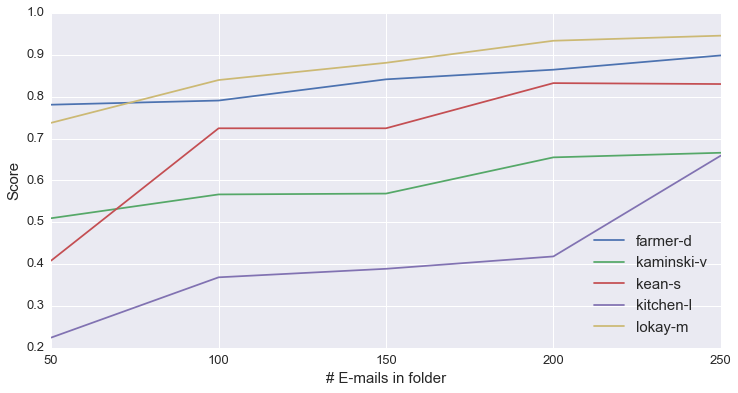

In [408]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
row1 = results.ix[1,:-1]
row2 = results.ix[2,:-1]
row3 = results.ix[3,:-1]
row4 = results.ix[4,:-1]
row5 = results.ix[5,:-1]

ax.plot(num_folders, row1, label = results.iloc[1]["employee"])
ax.plot(num_folders, row2, label = results.iloc[2]["employee"])
ax.plot(num_folders, row3, label = results.iloc[3]["employee"])
ax.plot(num_folders, row4, label = results.iloc[4]["employee"])
ax.plot(num_folders, row5, label = results.iloc[5]["employee"])

# Label and axis sizes
ax.tick_params(axis ='x', labelsize = 13)
ax.tick_params(axis ='y', labelsize = 13)
ax.yaxis.label.set_fontsize(15)
ax.xaxis.label.set_fontsize(15)

legend = ax.legend(loc = 'lower right')
ax.set_xlabel('# E-mails in folder')
ax.set_ylabel('Score')
plt.show()

**Figure 3**. Graph showing accuracy scores for 5 employees.  